# Cat vs Dog Image Classification

This notebook was created for [this](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview) expired Kaggle competition which aimed to classify cat and dog images.


In order to classify the images, I built two different models. 

* Typical CNN model: 
    * I built a typical model with Convolution layers and two hidden layer. This did not produce high accuracies, so I decided to build a pre-trained model instead.
* Xception model:
    * This produced better accuracies, so I used this model as my final submission to the Kaggle competition

## Typical CNN Model

In [1]:
import numpy as np
import pandas as pd

# for importing the data
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# For Building Model
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

# For Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For Prepare Training & Validating data
from sklearn.model_selection import train_test_split

# For Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

## Import and Format Data

To import and format the data, I took the following steps.
1. Imported the data
2. Split the training set into a training and validation set
3. Formated the data
    - Scaled
    - Sized

To complete these steps, I took inspiration from [this site.](https://www.kaggle.com/code/hebaatef/dogs-vs-cats-classification-using-keras-cnn#8.-Prepare-Testing-Data)

### Import Data

In [2]:
# list all files under current directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [3]:
ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip").extractall()

In [4]:
ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip").extractall()

In [5]:
# importing training data and assigning categories
train_files = os.listdir("./train")
train_categories = []

for file in train_files:
    category = file.split('.')[0]
    
    if category == "dog":
        train_categories.append(1)
    else:
        train_categories.append(0)
        
df = pd.DataFrame({
    'filename': train_files,
    'category': train_categories
})

df['category'] = df['category'].replace({0:'cat', 1:'dog'})
df.head()

,filename,category
0,dog.3038.jpg,dog
1,dog.9734.jpg,dog
2,cat.114.jpg,cat
3,dog.9417.jpg,dog
4,dog.1960.jpg,dog


### Split into Training and Validation Sets

In [6]:
# split train data frame into training and validation sets
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df

,filename,category
0,cat.9131.jpg,cat
1,dog.6553.jpg,dog
2,dog.4576.jpg,dog
3,dog.129.jpg,dog
4,cat.2064.jpg,cat
...,...,...
19995,cat.915.jpg,cat
19996,dog.1275.jpg,dog
19997,cat.1011.jpg,cat
19998,cat.11762.jpg,cat


### Format Data

* Scaled: To format the training and validation data, I scaled the pixels so that they are between 0 and 1.

* Sized: I sized the training and validation data to tensors that are 150x150, using 3 tensors for Red, Green, and Blue.

In [7]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
IMAGE_CHANNEL = 3
batch_size = 50

# scale training data
train_datagen = ImageDataGenerator(rescale=1./255)

# size training data
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train",
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=batch_size
    
)

Found 20000 validated image filenames belonging to 2 classes.


In [8]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [9]:
# scale validation data
validate_datagen = ImageDataGenerator(rescale=1./255)

# size validation data
validate_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    "./train",
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [10]:
validate_generator.class_indices

{'cat': 0, 'dog': 1}

## Build and Fit Typical CNN Model

I used [this](https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697) site for inspiration when building the model.

In [11]:

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNEL)
nb_classes = 1 # output probability of one class

nb_filters = 25 # the number of filters/kernels
nb_pool = 2 # window size of pooling
nb_conv = 3 # window size of filter/kernels

nb_epoch = 3

model = Sequential()


# convolutional layer 1
model.add(Conv2D(32, kernel_size=nb_conv, input_shape=input_shape, activation='relu', padding="SAME"))

# convolutional layer 2
model.add(Conv2D(64, kernel_size=nb_conv, activation='relu', padding="SAME"))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

# convolutional layer 3
model.add(Conv2D(128, kernel_size=nb_conv, activation='relu', padding="SAME"))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(BatchNormalization())

# flatten image to 1D array
model.add(Flatten())

# hidden layer 1 + dropout to reduce overfitting
model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# hidden layer 2 + dropout to reduce overfitting
model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# output layer
model.add(Dense(nb_classes, activation='sigmoid'))


2022-03-30 20:40:24.948854: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 37, 128)       512       
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0

In [13]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_generator, 
          epochs=10, 
          steps_per_epoch=train_df.shape[0]//batch_size, 
          validation_data=validate_generator)

2022-03-30 20:40:26.241308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
400/400 [==============================] - 1568s 4s/step - loss: 164.2788 - binary_accuracy: 0.5616 - val_loss: 101.7762 - val_binary_accuracy: 0.4948
Epoch 2/10
400/400 [==============================] - 1563s 4s/step - loss: 100.7080 - binary_accuracy: 0.6213 - val_loss: 99.4039 - val_binary_accuracy: 0.5670
Epoch 3/10
400/400 [==============================] - 1563s 4s/step - loss: 99.5324 - binary_accuracy: 0.6457 - val_loss: 98.9320 - val_binary_accuracy: 0.6496
Epoch 4/10
400/400 [==============================] - 1564s 4s/step - loss: 99.7904 - binary_accuracy: 0.6700 - val_loss: 103.3431 - val_binary_accuracy: 0.5052
Epoch 5/10
400/400 [==============================] - 1566s 4s/step - loss: 101.3142 - binary_accuracy: 0.6837 - val_loss: 102.5884 - val_binary_accuracy: 0.5356
Epoch 6/10
400/400 [==============================] - 1565s 4s/step - loss: 102.1346 - binary_accuracy: 0.7111 - val_loss: 102.0342 - val_binary_accuracy: 0.6126
Epoch 7/10
400/400 [============

We can see that this model is overfitting in some of the earlier epochs because the accuracy on the training set is much higher than the accuracy on the validation set. The accuracies are also relatively low, but I will still visualize the model's prediction on one image.

### Test out Model

I used this [site](https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697) to built a function that will print out images and their predictions.

In [14]:
# testing
test_files = os.listdir("./test")
test_df = pd.DataFrame({
    'filename': test_files
})
nb_samples = test_df.shape[0]

In [15]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("DOG",fontsize=30)
        
    
    elif val == 0:
        
        plt.xlabel("CAT",fontsize=30)


[[1.]]


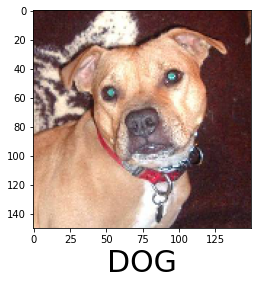

In [16]:
predictImage(r'./test/2.jpg')

## Xception Model

In [1]:
import numpy as np
import pandas as pd

# for importing the data
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# For Building Typical NN Model
import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization

# For Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For Preparing Training & Validation data
from sklearn.model_selection import train_test_split

# For Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# for pre-trained models
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow import keras

## Import and Format Data

To import and format the data, I took the following steps.
1. Imported the data
2. Split the training set into a training and validation set
3. Formated the data
    - Scaled
    - Augmented
    - Sized

To complete these steps, I took inspiration from [this site.](https://www.kaggle.com/code/hebaatef/dogs-vs-cats-classification-using-keras-cnn#8.-Prepare-Testing-Data)

### Importing Data

In [2]:
# list all files under current directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [3]:
ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip").extractall()

In [4]:
ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip").extractall()

In [5]:
# importing training data and assigning categories
train_files = os.listdir("./train")
train_categories = []

for file in train_files:
    category = file.split('.')[0]
    
    if category == "dog":
        train_categories.append(1)
    else:
        train_categories.append(0)
        
df = pd.DataFrame({
    'filename': train_files,
    'category': train_categories
})

df['category'] = df['category'].replace({0:'cat', 1:'dog'})
df.head()

,filename,category
0,dog.2688.jpg,dog
1,dog.1343.jpg,dog
2,dog.11387.jpg,dog
3,dog.5935.jpg,dog
4,dog.2100.jpg,dog


### Split into Training and Validation Sets

In [6]:
# split train data frame into training and validation sets
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df

,filename,category
0,cat.10325.jpg,cat
1,cat.1791.jpg,cat
2,cat.3261.jpg,cat
3,cat.438.jpg,cat
4,cat.12102.jpg,cat
...,...,...
19995,cat.4677.jpg,cat
19996,cat.5668.jpg,cat
19997,dog.6679.jpg,dog
19998,cat.1263.jpg,cat


### Data Formatting

* Scaled: To format the training and validation data, I scaled the pixels so that they are between -1 and 1,  the desired scale for an Xception model. I used this [website](https://stackoverflow.com/questions/62836692/imagedatagenerator-rescaling-to-1-1-instead-of-0-1) to scale the data. 

* Augmented: I augmented only the training data using the ImageDataGenerator() function. This process artificially expands the size of the training dataset by creating variations of the images to improve the model's ability to generalize on new images. I used this [website](https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/) to understand how to augment the training data.

* Sized: I sized the training and validation data to tensors that are 299x299, using 3 tensors for Red, Green, and Blue. This is the default input image size for an Xception model.

In [7]:
# format training data
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
IMAGE_CHANNEL = 3
batch_size = 16

# scale data to scale between -1 and 1
def preprocess_function(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

# scale and augment data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_function,
                                   rotation_range=90,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.2,1.2])

# size data to desired size
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train",
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=batch_size
    
)

Found 20000 validated image filenames belonging to 2 classes.


In [8]:
# format validation data
validate_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    "./train",
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.




## Building Xception Model

The Xception model is a pre-trained model that merges the idea of GoogleLeNet and ResNet. Instead of using Inception Modules, Xception uses a depthwise separable convolution layer. When building the Xception model, I used the following sites to understand how to build the model.

https://keras.io/api/applications/xception/

https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

https://keras.io/guides/transfer_learning/

In [9]:
# build model
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False,
                                                  input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))

# create new model on top of Xception model
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
drop = keras.layers.Dropout(0.2)(avg)
output = keras.layers.Dense(1, activation="sigmoid")(drop)

model = keras.models.Model(inputs=base_model.input, outputs=output)

# freeze layers
for layer in base_model.layers:
    layer.trainable = False
    
model.summary()

2022-03-29 21:52:40.766643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 21:52:40.887778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 21:52:40.888879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 21:52:40.891493: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

83697664/83683744 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [10]:
# compile and fit model

optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_generator, 
          epochs=10, 
          steps_per_epoch=train_df.shape[0]//batch_size,
          validation_data=validate_generator,
          validation_steps=validate_df.shape[0]//batch_size)

2022-03-29 21:52:48.378943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-29 21:52:52.951610: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 571s 449ms/step - loss: 0.1560 - binary_accuracy: 0.9577 - val_loss: 0.0452 - val_binary_accuracy: 0.9900
Epoch 2/10
1250/1250 [==============================] - 564s 451ms/step - loss: 0.0891 - binary_accuracy: 0.9682 - val_loss: 0.0327 - val_binary_accuracy: 0.9916
Epoch 3/10
1250/1250 [==============================] - 572s 457ms/step - loss: 0.0764 - binary_accuracy: 0.9725 - val_loss: 0.0296 - val_binary_accuracy: 0.9914
Epoch 4/10
1250/1250 [==============================] - 575s 460ms/step - loss: 0.0738 - binary_accuracy: 0.9722 - val_loss: 0.0283 - val_binary_accuracy: 0.9908
Epoch 5/10
1250/1250 [==============================] - 579s 463ms/step - loss: 0.0737 - binary_accuracy: 0.9713 - val_loss: 0.0288 - val_binary_accuracy: 0.9902
Epoch 6/10
1250/1250 [==============================] - 594s 475ms/step - loss: 0.0725 - binary_accuracy: 0.9723 - val_loss: 0.0273 - val_binary_accuracy: 0.9908
Epoch 7/10
1250/1250 [=================

In [11]:
# unfreeze layers
for layer in base_model.layers:
    layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [12]:
# compile and fit model
optimizer = keras.optimizers.Adamax(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_generator, 
          epochs=10, 
          steps_per_epoch=train_df.shape[0]//batch_size,
          validation_data=validate_generator,
          validation_steps=validate_df.shape[0]//batch_size)

Epoch 1/10
1250/1250 [==============================] - 773s 614ms/step - loss: 0.1678 - binary_accuracy: 0.9359 - val_loss: 0.0386 - val_binary_accuracy: 0.9872
Epoch 2/10
1250/1250 [==============================] - 767s 614ms/step - loss: 0.1073 - binary_accuracy: 0.9586 - val_loss: 0.0288 - val_binary_accuracy: 0.9908
Epoch 3/10
1250/1250 [==============================] - 787s 630ms/step - loss: 0.0920 - binary_accuracy: 0.9656 - val_loss: 0.0275 - val_binary_accuracy: 0.9916
Epoch 4/10
1250/1250 [==============================] - 743s 594ms/step - loss: 0.0915 - binary_accuracy: 0.9663 - val_loss: 0.0250 - val_binary_accuracy: 0.9928
Epoch 5/10
1250/1250 [==============================] - 730s 584ms/step - loss: 0.0810 - binary_accuracy: 0.9689 - val_loss: 0.0233 - val_binary_accuracy: 0.9930
Epoch 6/10
1250/1250 [==============================] - 735s 588ms/step - loss: 0.0753 - binary_accuracy: 0.9721 - val_loss: 0.0216 - val_binary_accuracy: 0.9938
Epoch 7/10
1250/1250 [======

## Predict on Testing Data

In [13]:
# testing
test_files = os.listdir("./test")
test_df = pd.DataFrame({
    'filename': test_files
})
nb_samples = test_df.shape[0]

In [14]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)
test_generator =  test_datagen.flow_from_dataframe(
    test_df,
    "./test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [15]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [16]:
id = test_df['filename'].apply(lambda x: int(x.split('.')[0]))

In [17]:
# prepare for submission
submission = pd.DataFrame({'id':list(id),'label':predict[:,0]}).sort_values(by='id').reset_index(drop=True)

In [18]:
submission.to_csv("MSBA_Session1_LydiaSavatsky.csv",index=False)